In [1]:
from __future__ import division, print_function
import sys, os, glob, gc, warnings
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import matplotlib.pyplot as plt

import healpy as hp

from desiutil.plots import init_sky, plot_sky_binned

In [2]:
# params = {'legend.fontsize': 'x-large',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large',
#          'figure.facecolor':'w'} 
# plt.rcParams.update(params)

In [3]:
sweep = fitsio.read('/global/cscratch1/sd/rongpu/temp/dr8_sky_residual_south.fits')
sweep = Table(sweep)
print(len(sweep))

# ELG mask
mask_clean = ((sweep['MASKBITS'] & 2**5)==0) & ((sweep['MASKBITS'] & 2**6)==0) & ((sweep['MASKBITS'] & 2**7)==0)
mask_clean &= ((sweep['MASKBITS'] & 2**1)==0) & ((sweep['MASKBITS'] & 2**11)==0) & ((sweep['MASKBITS'] & 2**12)==0) & ((sweep['MASKBITS'] & 2**13)==0)

23654094


__For simplicity, here we only look at g-band__

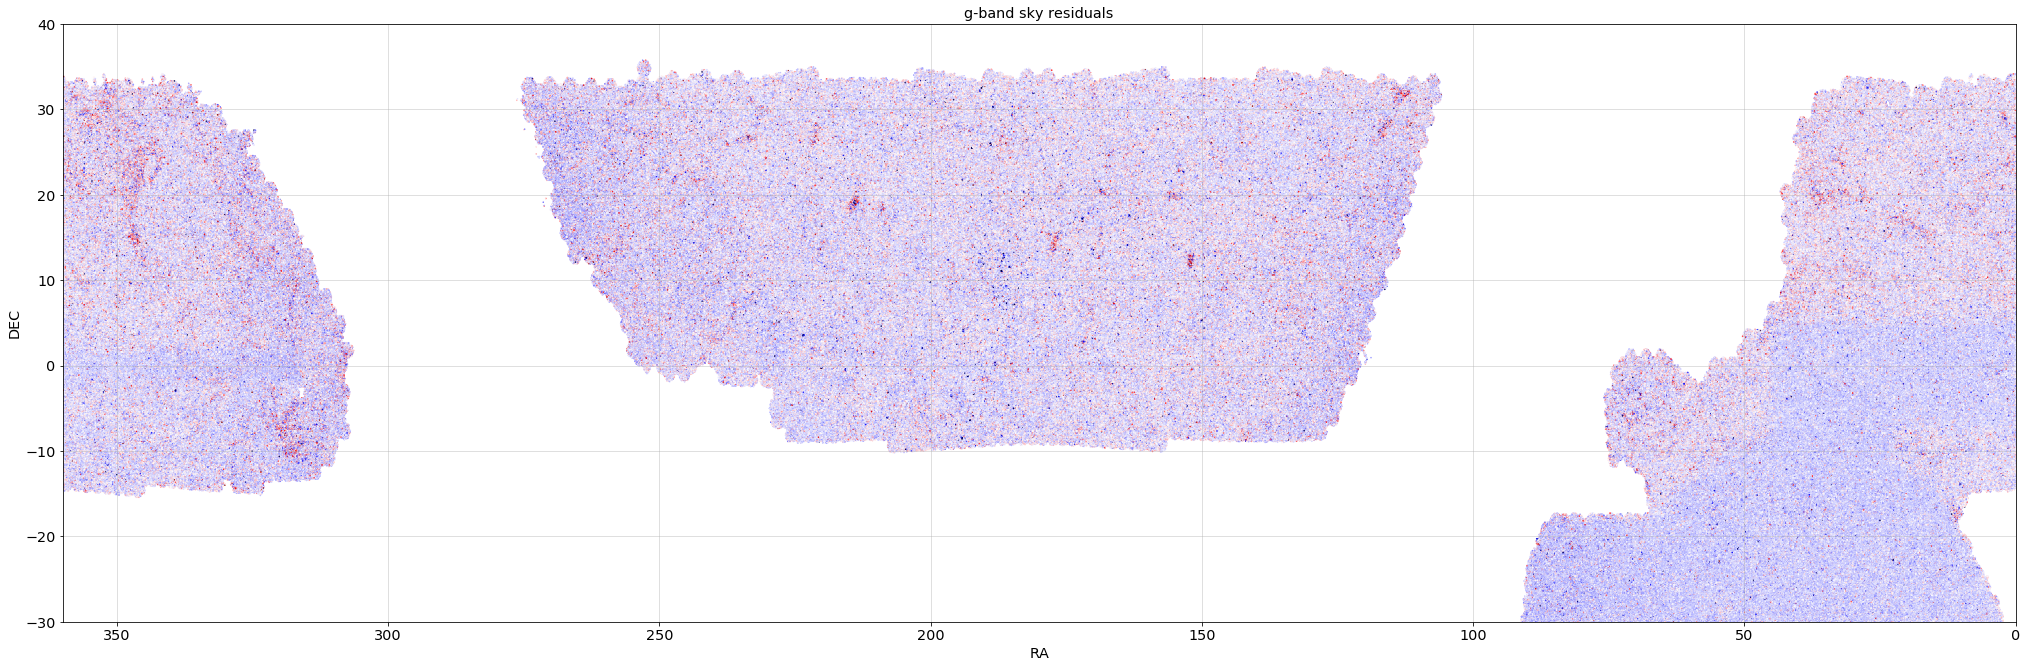

In [4]:
for band in ['g']:
    fig, ax = plt.subplots(figsize=(35, 11))
    im = ax.scatter(sweep['RA'][mask_clean][::10], sweep['DEC'][mask_clean][::10], c=sweep[band+'_sky'][mask_clean][::10], vmin=-0.02, vmax=0.02, s=0.3, alpha=1., cmap='seismic')
    ax.axis([360, 0, -30, 40])
    ax.grid(alpha=0.5)
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    # fig.colorbar(im)
    ax.set_title(band+'-band sky residuals')
    plt.show()

sweep objects: median g-band sky residuals per sq arcsec: -0.00115


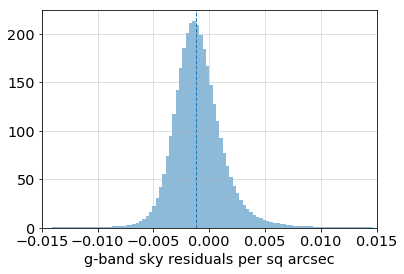

In [5]:
histrange = 0.015
for band in ['g']:
    sweep_g_sky = sweep[band+'_sky'][mask_clean]
    print('sweep objects: median {}-band sky residuals per sq arcsec: {:.5f}'.format(band, np.median(sweep_g_sky)))
    plt.hist(sweep_g_sky, 100, range=(-histrange, histrange), density=True, alpha=0.5)
    plt.axvline(np.median(sweep_g_sky), color='C0', ls='--', lw=1)
    plt.xlim(-histrange, histrange)
    plt.grid(alpha=0.5)
    plt.xlabel(band+'-band sky residuals per sq arcsec')
    plt.show()
print()

In [6]:
# Downsampling sweep
np.random.seed(123)
idx = np.sort(np.random.choice(len(sweep), size=len(sweep)//2, replace=False))

print(len(sweep))
sweep = sweep[idx]
print(len(sweep))

23654094
11827047


In [9]:
nside = 64
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)

# Assign objects to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, sweep['RA'], sweep['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
count = np.zeros(npix)
count[pix_unique] = pix_count

hp_mask = count>10

In [11]:
hp_table = Table()
hp_table['hp_idx'] = np.arange(npix)
hp_table['count'] = count

tmp = np.zeros([npix, 3])
hp_table1 = Table(tmp, names=('g_sky', 'r_sky', 'z_sky'))
hp_table = hstack([hp_table, hp_table1])

for index in range(len(pix_unique)):

    if (index+1)%(len(pix_unique)//10)==0:
        print('{:.0f}%'.format(index/(len(pix_unique))*100))

    mask = (pix==pix_unique[index])
    
    hp_table['g_sky'][pix_unique[index]] = np.median(sweep['g_sky'][mask])
    hp_table['r_sky'][pix_unique[index]] = np.median(sweep['r_sky'][mask])
    hp_table['z_sky'][pix_unique[index]] = np.median(sweep['z_sky'][mask])
    
hp_table['ra'], hp_table['dec'] = hp.pixelfunc.pix2ang(64, hp_table['hp_idx'], lonlat=True)

mask = hp_table['count'] < 10
hp_table['count'][mask] = None
hp_table['g_sky'][mask] = None
hp_table['r_sky'][mask] = None
hp_table['z_sky'][mask] = None

hp_table.write('data/sky_residual_dr8_south_64.txt', format='ascii.commented_header')

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [3]:
hp_table = Table.read('data/sky_residual_dr8_south_64.txt', format='ascii.commented_header')

In [24]:
col_list = ['count', 'g_sky', 'r_sky', 'z_sky']
clip_lo_list = [0, -0.003, -0.004, -0.006]
clip_hi_list = [None, 0.003, 0.004, 0.006]

cmap_list = ['jet', 'seismic', 'seismic', 'seismic']

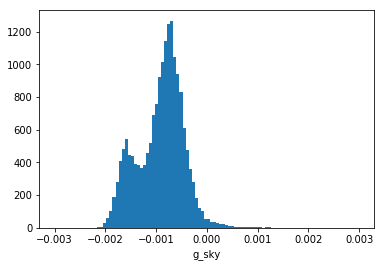

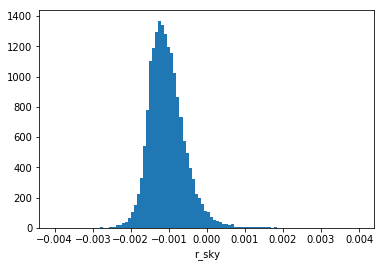

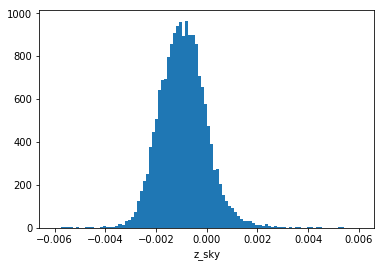

In [36]:
for col, clip_lo, clip_hi in zip(col_list, clip_lo_list, clip_hi_list):
    if col=='count':
        continue 
    v = hp_table[col]
    plt.hist(v[np.isfinite(v)], 100, range=(clip_lo, clip_hi))
    plt.xlabel(col)
    plt.show()

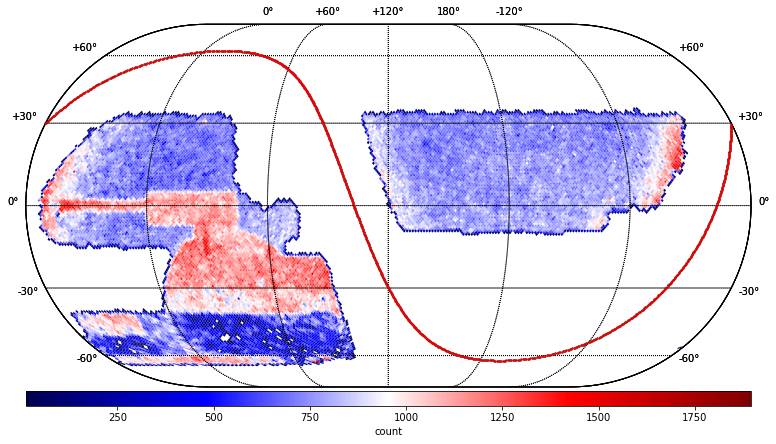

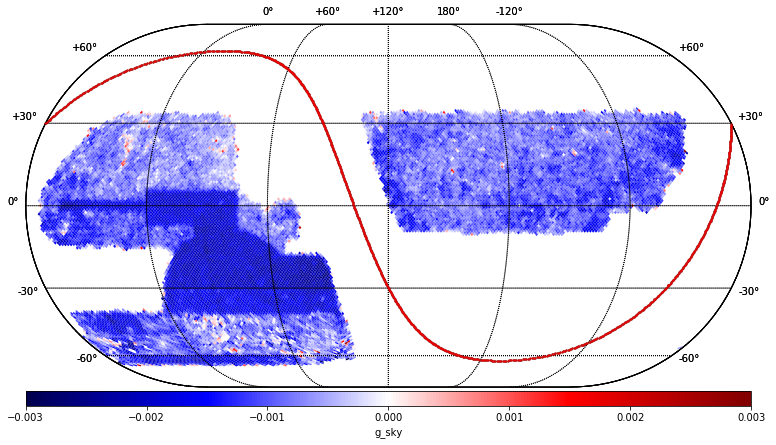

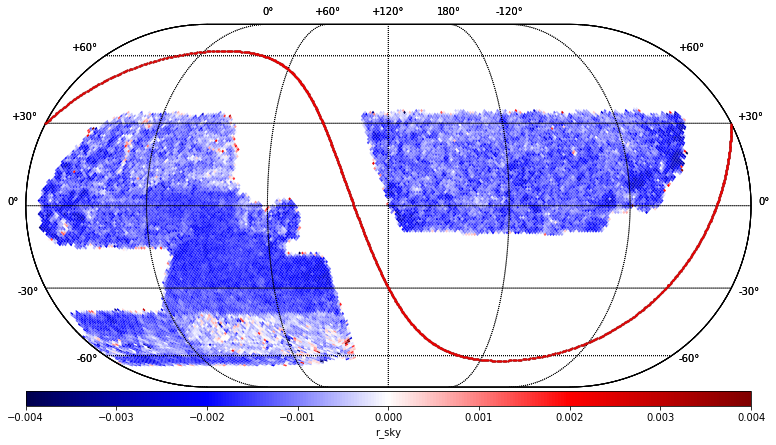

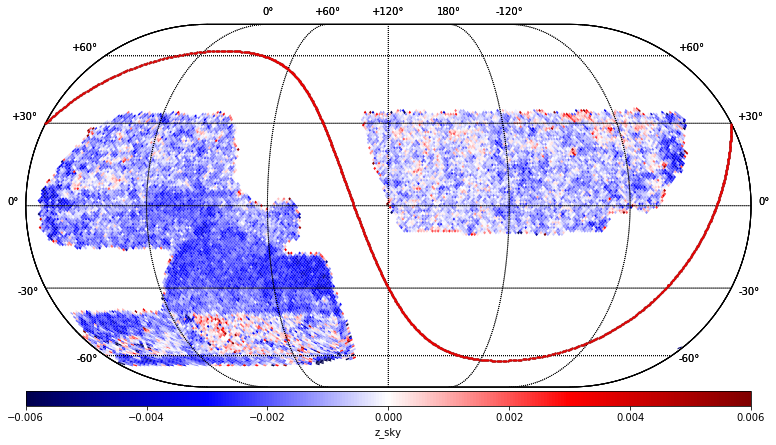

In [23]:
for col, clip_lo, clip_hi in zip(col_list, clip_lo_list, clip_hi_list):
    fig, ax = plt.subplots(1, figsize=(13, 8))
    ax = np.atleast_1d(ax)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax[0])
        plot_sky_binned(hp_table['ra'], hp_table['dec'], weights=hp_table[col], 
                       cmap='seismic', plot_type='healpix', label=col, clip_lo=clip_lo, clip_hi=clip_hi, max_bin_area=3)
    plt.show()